In [145]:
import hashlib
import os
import pickle
from configparser import ConfigParser
import firebase_admin
import joblib
import numpy as np
from firebase_admin import db
from flask import Flask, send_from_directory, request, redirect, url_for, session
from flask import render_template
from sklearn.datasets import fetch_20newsgroups
categories = ['comp.os.ms-windows.misc', 'sci.crypt']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=('footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=('footers', 'quotes'))

from sklearn.neighbors import KNeighborsRegressor

In [146]:
tr_data = [newsgroups_train.data[i] for i in np.arange(300)]
te_data = [newsgroups_test.data[i] for i in np.arange(200)]
data = tr_data + te_data

In [147]:
DATA_PATH = "/data/arun/Dropbox (ASU)/code_for_Arun/text_data/comp_vs_sci_flipped0.3/"
MODEL_PATH= "/data/arun/research/projects/crowdsourcing/kdd-2019/cache/txt/model_txt_unbiased.dat"

# Load the Data.
tr_X = pickle.load(open(os.path.join(DATA_PATH, 'features_train.pickle'), 'rb'))
te_X = pickle.load(open(os.path.join(DATA_PATH, 'features_test.pickle'), 'rb'))
tr_y = pickle.load(open(os.path.join(DATA_PATH, 'labels_train_prediction.pickle'), 'rb'))
tr_y = np.argmax(tr_y, axis=1)
tr_y = tr_y*2.-1.

te_y = pickle.load(open(os.path.join(DATA_PATH, 'labels_test_prediction.pickle'), 'rb'))
te_y = np.argmax(te_y, axis=1)
te_y = te_y*2.-1.


X = np.vstack([tr_X.todense(), te_X.todense()])
Y = np.hstack([tr_y, te_y])

X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

In [148]:
tr_X.shape

(300, 120)

In [149]:
te_X.shape

(200, 120)

In [150]:
X.shape

(500, 121)

In [151]:
Y.shape

(500,)

In [152]:
model = joblib.load(MODEL_PATH)
W = model.coefficients()

In [153]:
W.shape

(121,)

In [196]:
# dist = np.dot(X,W)

dist = np.dot(X,W)

dist2 = np.dot(X,W)/np.linalg.norm(W, ord=2)

dist = np.asarray(dist).reshape(-1)

In [197]:
INF_RESULTS_PATH = '/data/arun/research/projects/crowdsourcing/kdd-2019/cache/txt/influence_scores_txt_unbiased.dat'

In [198]:
# load influence influence scores.
inf_scores = joblib.load(INF_RESULTS_PATH)
I = np.mean(inf_scores, axis=1)

In [199]:
inf_scores.shape

(500, 300)

In [200]:
I.shape

(500,)

In [201]:
from scipy.stats.stats import pearsonr, kendalltau   
from scipy.stats import zscore

In [202]:
pearsonr(dist,I)

(0.04324619203273553, 0.3345220391278735)

In [203]:
marginal_dist = 1 / (1 + np.exp(-dist))

In [204]:
marginal_dist = marginal_dist - 0.5

In [205]:
pearsonr(marginal_dist,I)

(0.04381076381486112, 0.32824448671618534)

In [288]:
plt.rcParams.update({'font.size': 15})


def compute_scale_plot(x,y, dist2):
    
    
    dist2 = np.abs(dist2)
    _x = MinMaxScaler().fit_transform(x.reshape(-1,1)).reshape(-1)
    _y = MinMaxScaler().fit_transform(y.reshape(-1,1)).reshape(-1)
    _dist2 = MinMaxScaler().fit_transform(dist2.reshape(-1,1)).reshape(-1)
    
    
    c,p =pearsonr(_x,_y)
    
    c = c + 0.2
    
    
    idx2 = np.argsort(_dist2)
    
    idx = np.argsort(_y)
    inds = np.arange(len(idx))
    plt.figure(figsize=(5,6))
    # plt.scatter(i_nf, x[idx_nf],label='Normalized influence score - non flipped')
    # plt.scatter(i_f, x[idx_f],label='Normalized influence score - flipped', marker='x')

    plt.scatter(inds, _x[idx],label='Influence',  marker='x')
    #plt.scatter(inds, _y[idx], label='Normalized marginal distance')
    plt.scatter(inds, _dist2[idx2], label='Marginal distance')
    
    plt.xlabel('Marginal distance based \n ranked index of text items')
    plt.ylabel('Normalized value')
    plt.title('(c) Text (r=-0.348, p=0.001)'.format(c,p))
    plt.legend()
    plt.tight_layout()
    
    plt.savefig('marginal_influence_results_txt.png', dpi=300)
    plt.savefig('marginal_influence_results_txt.pdf', dpi=300)

In [286]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [276]:
compute_scale_plot(I[300:], marginal_dist[300:])

TypeError: compute_scale_plot() missing 1 required positional argument: 'dist2'

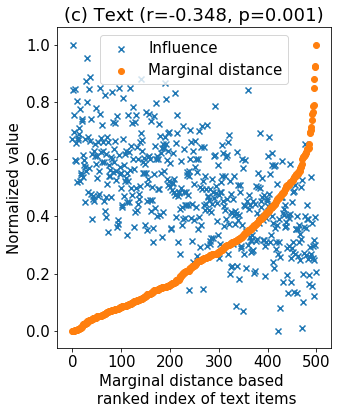

In [289]:
dX = marginal_dist[300:]
dy1 = I[300:]



neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(dX.reshape(-1,1),dy1)

dy2 = neigh.predict(marginal_dist[:300].reshape(-1,1))

dy2 = dy2 + np.random.randn(dy2.shape[0])*0.0002
dy1 = dy1 + np.random.randn(dy1.shape[0])*0.0002


dy = np.asarray(list(dy2)+ list(dy1))

compute_scale_plot(dy, marginal_dist, dist2)